In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.cross_decomposition import PLSRegression

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
## arrange data
## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)


female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/ontogeny_females_raw_usage_df_beh_age.parquet').astype(float)
female_df = female_df[keep_syllables]



# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [6]:
#average and normalize female
avg_f_df = f_df.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

In [7]:
df = f_norm.copy()

In [8]:
pc = PCA(n_components=3)
pcss = pc.fit_transform(df)

In [9]:
pcs = pd.DataFrame(pcss, columns=['PC1','PC2','PC3'])
pcs['age'] = df.index.get_level_values('age')

In [10]:
age_pc = pcs.groupby('age').mean()

In [11]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)

In [12]:
print(cumulative_variance_explained)
format_plots()

[0.15986743 0.30280368 0.42426734]


In [13]:
# Create a colormap
#colors = plt.cm.cmf(np.linspace(0, 1, len(pcs)))
from matplotlib.collections import LineCollection
# Create segments for LineCollection
points = np.array([age_pc['PC1'],age_pc['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1))
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))

Text(0, 0.5, 'PC2')

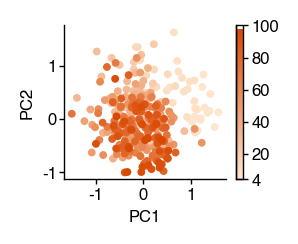

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1) 
im = ax.scatter(x=pcs['PC1'], y=pcs['PC2'], 
                cmap=cmf,
                s=8,
                edgecolor='none',
                c=pcs['age'], 
               )
cb=fig.colorbar(im,ax=ax)
tick_values = [4,20,40,60,80,100]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])

sns.despine()
#plt.title('female ontogeny')
plt.xlabel('PC1')
plt.ylabel('PC2')

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "bio"/ 'PCA_female_norm.pdf')

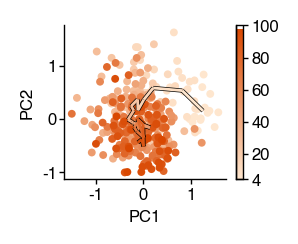

In [16]:
# Create segments for LineCollection
points = np.array([age_pc['PC1'], age_pc['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))
# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=1.5)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1)

# Scatter plot
im = ax.scatter(
    x=pcs['PC1'], y=pcs['PC2'], 
    c=pcs['age'], 
    cmap=cmf,
    s=8,
    edgecolor='none',
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [4,20,40,60,80,100]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])


# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [17]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "bio"/ 'PCA_female_norm_line.pdf')

In [18]:
#PC1 correlation
from scipy import stats
[cm,pm] = stats.spearmanr(pcs['age'], pcs['PC1'])
print(cm)

-0.23384936266322226


/tmp/ipykernel_11500/427564117.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


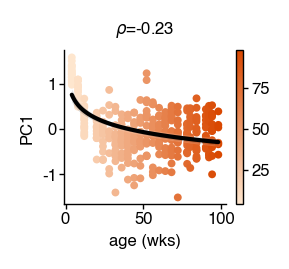

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1) 
plt.scatter(x=pcs['age'], y=pcs['PC1'], 
            s=8, 
            c=pcs['age'], 
            edgecolor='none',
            #linewidth=0.25,
            #norm='log',
            #alpha=0.75,
            cmap=cmf)
ax = sns.regplot(data=pcs, x='age', y=pcs['PC1'], scatter=False, color='black',
                 logx=True,x_ci='sd',
                )
ax.set(xlabel='age (wks)', ylabel='PC1')
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcs['age'].min(), pcs['age'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

c = PlotConfig()
fig.savefig(c.dana_save_path / "bio"/ 'PCA_female_pc1_corr.pdf')